### Lib loading and functions definition

In [1]:
from datasetsforecast.m4 import M4
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from mlforecast.target_transforms import Differences
from numpy import sqrt, ndarray, zeros
import pandas as pd
import random
from seaborn import set_style
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator
from sklearn.neural_network import MLPRegressor

from src.lags_selection import LagsSelector

set_style("darkgrid")

In [2]:
def plot_dataset(df: pd.DataFrame, name: str, forecast: pd.DataFrame = None, color: str = None) -> None:
    plt.figure(figsize=(15, 5))
    plt.plot(df.loc[:, 'ds'], df.loc[:, 'y'], color = color if color else "orangered")
    if forecast is not None:
        plt.plot(forecast.loc[:, 'ds'], forecast.loc[:, 'forecast'], color = "dodgerblue")
    plt.title(name, color = "black")
    plt.xlabel("Time stamp", color = "black")
    plt.ylabel("Value", color = "black")
    plt.show()
    

# Can score using your own metric
def rmse(y_true: ndarray, y_pred: ndarray) -> float:
    """Root mean squared error.

    Args:
        y_true (ndarray): The vector of true data.
        y_pred (ndarray): The vector of forecasted data.

    Returns:
        float: The root mean squared error.
    """
    return sqrt(mean_absolute_error(y_true, y_pred))

### LightGBM and Tree Explainer

This notebook uses M4 data as an example :

In [3]:
await M4.async_download('data', group='Hourly')
df, *_ = M4.load('data', 'Hourly')
uids = df['unique_id'].unique()
random.seed(100)
sample_uids = random.choices(uids, k=1)
serie = df[df['unique_id'].isin(sample_uids)].reset_index(drop=True)
serie['ds'] = serie['ds'].astype('int64')
name = sample_uids[0]

LagsSelector wrap over the MLForecast and SHAP libraries. At the init, you must specify the same parameters as the MLForecast.<br>
To learn more about MLForecast, please visit : https://nixtlaverse.nixtla.io/mlforecast/index.html#sample-notebooks.

In [4]:
selector = LagsSelector(estimator=LGBMRegressor(verbose = -1),
                        lags = [i for i in range(1, 25)],
                        target_transforms=[Differences([24])] # No trend, just removing the seasonality
                        )

The selector adapts the methods explained in :<br>
https://medium.com/towards-data-science/your-features-are-important-it-doesnt-mean-they-are-good-ff468ae2e3d4 to the time serie context. <br><br>
As explained in the article, you can perform recursive feature elimination either by removing at each step the less important feature in the prediction contribution (```method="prediction"```) or by removing the mort important feature in the prediction error (```method="error"```).<br><br>
If method is set to ```"both"```, the selector will perform both methods and return the best result of the two methods.

100%|██████████| 24/24 [00:32<00:00,  1.34s/it]


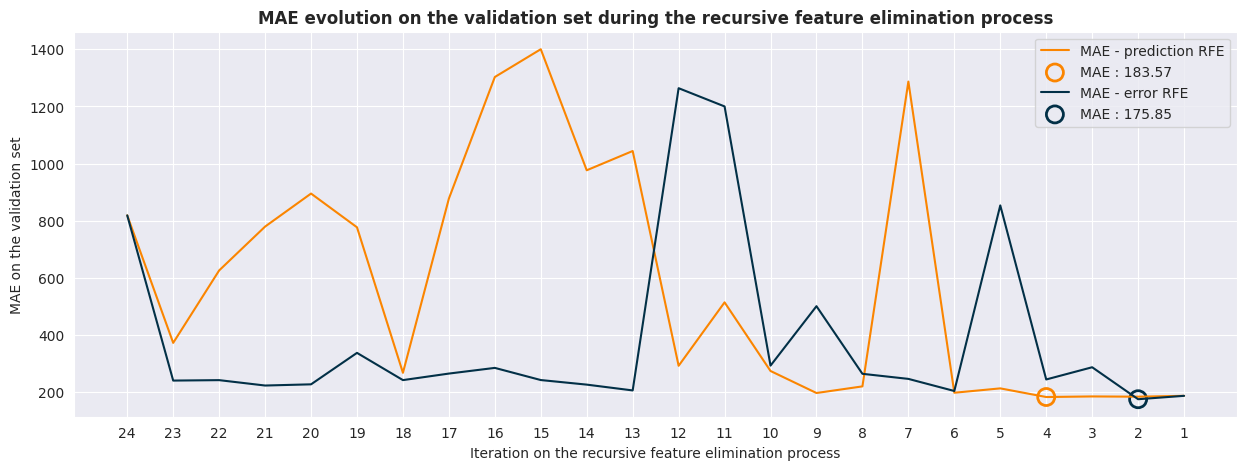

LagsSelector(best_forecaster_=None, best_params_=[1, 2, 8, 22],
             best_score_=[1, 2, 8, 22],
             error_rfe_results_=    n_features     mae_trn      mae_tst    R2_trn    R2_tst  lag_drop  \
0         24.0   41.566295   818.997946  0.947680 -0.321342         2   
1         23.0   42.403356   241.082015  0.940683  0.388281         3   
2         22.0   43.446419   242.608837  0.940148  0.360759         4   
3         21.0   46.982323   223.756787  0.920865  0.399484        22   
4         20.0   48.843006   227.947349  0.920976  0.4296...
21         3.0   74.902775   185.597720  0.823961  0.324003         2   
22         2.0   84.918382   184.705000  0.785149  0.336527        22   
23         1.0  110.115625   187.738764  0.465381  0.327577         1   

       contrib  
0     2.448587  
1     2.361106  
2     2.293907  
3     2.190774  
4     4.197319  
5     4.528674  
6     5.970418  
7     6.238269  
8     6.506276  
9     9.224462  
10   10.028573  
11    7.403019  
12    8.430358  
13   15.109094  
14   15.050778  
15   16.695083  
16   19.173744  
17   18.477247  
18   17.173022  
19   22.143236  
20   23.345265  
21   33.527495  
22   42.520556  
23  144.067473  )

In [5]:
selector.fit(X = serie, explainer = "TreeExplainer", method = "both")

If ```plot=True```, which is the default case, the result of the fitting will plot the error (mae) for each iteration of the recursive feature elimination process.

In [6]:
# The parameters of the selector
selector.get_params().keys()

dict_keys(['best_forecaster_', 'best_params_', 'best_score_', 'error_rfe_results_', 'prediction_rfe_results_'])

When passing your dataset to the selector, a part of it is keeped for testing. You can test the performance of the best forecaster according to the RFE process by calling the ```score``` method. <br><br>

Note that you can score with your own scoring function, for instance here the ```rmse``` defined at the top of the notebook. Default scoring is the ```mean_absolute_error``` from sklearn.

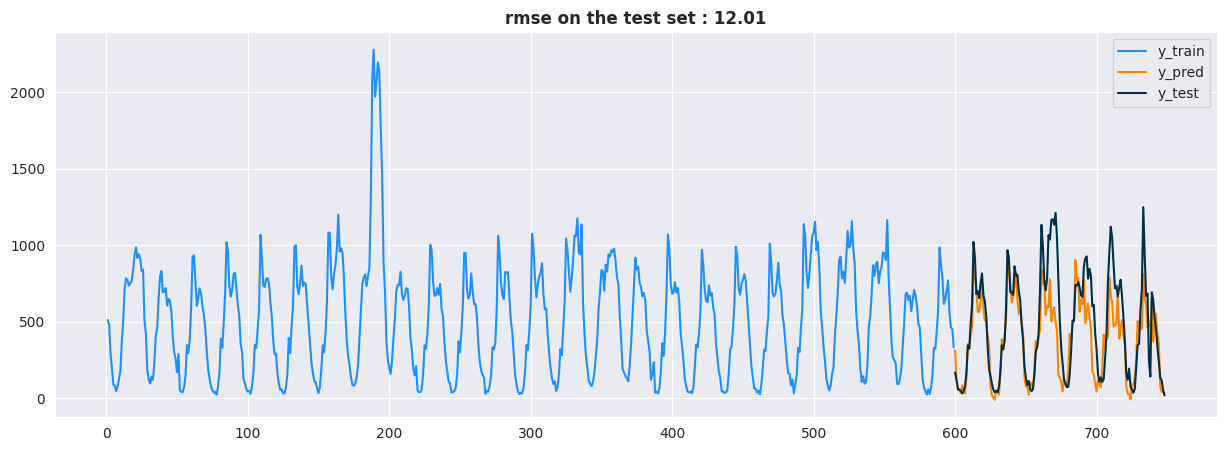

The RMSE is: 12.01, i.e 3.34% of the serie's standard deviation


In [7]:
rmse_eval = selector.score(plot=True, scoring=rmse, show_train=True)
print(f"The RMSE is: {rmse_eval:.2f}, i.e {rmse_eval/serie['y'].std()*100:.2f}% of the serie's standard deviation")

Each RFE algorithm takes a specific trajectory. In some rare cases, those path could be the same. You can get and visualize them calling the ```get_paths``` method.

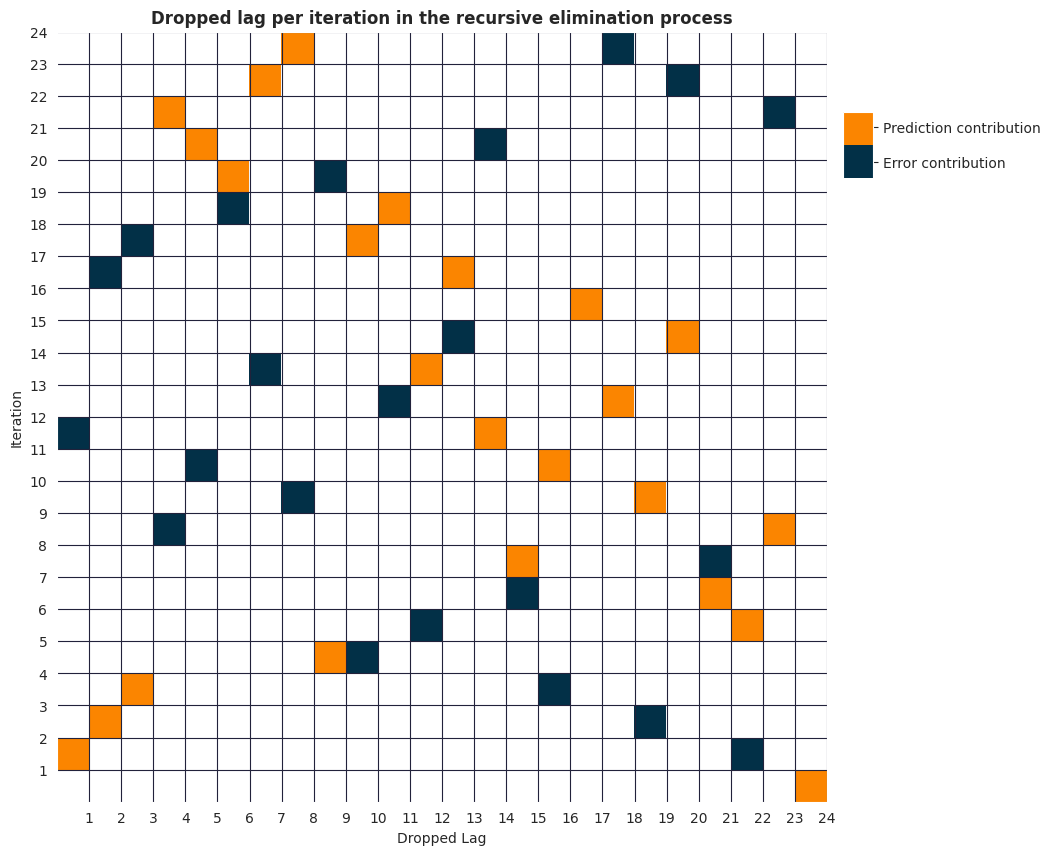

In [8]:
prediction_path, error_path = selector.get_paths(plot=True)

After the fitting of the selector is complete, one can access the best forecaster (which is a ```MLForecast```) and the lags associated.

In [9]:
fcster = selector.best_forecaster_
lags = selector.best_params_

fcster, lags

(MLForecast(models=[LGBMRegressor], freq=1, lag_features=['lag1', 'lag2', 'lag8', 'lag22'], date_features=[], num_threads=1),
 [1, 2, 8, 22])

Forecasting the next week :

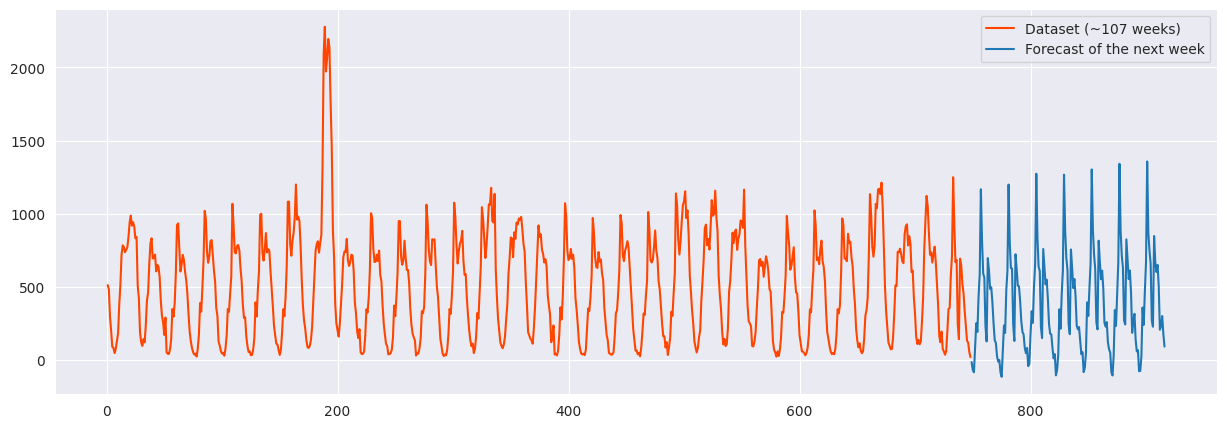

In [10]:
p = selector.best_forecaster_.predict(h = 7*24)
plt.figure(figsize=(15, 5))

plt.plot(serie.loc[:, "ds"], serie.loc[:, "y"], color = "orangered", label = f"Dataset (~{serie.shape[0]/7:.0f} weeks)")
plt.plot(p.loc[:, "ds"], p.iloc[:, -1], label = "Forecast of the next week")
plt.legend()
plt.show()

### Neural Network and Permutation explainer

Here is an example showing how to use another scikitlearn model and another SHAP explainer. List of the SHAP explainer available are accessible in the docstring in the ```fit``` method. <br>Note that all the explainer are not compatible with all the models. ```LinearExplainer``` for instance will want a linear model and other types of models will return an error.

In [11]:
random.seed(500) # changing the seed to get another time serie
sample_uids = random.choices(uids, k=1)
serie = df[df['unique_id'].isin(sample_uids)].reset_index(drop=True)
serie['ds'] = serie['ds'].astype('int64')
name = sample_uids[0]

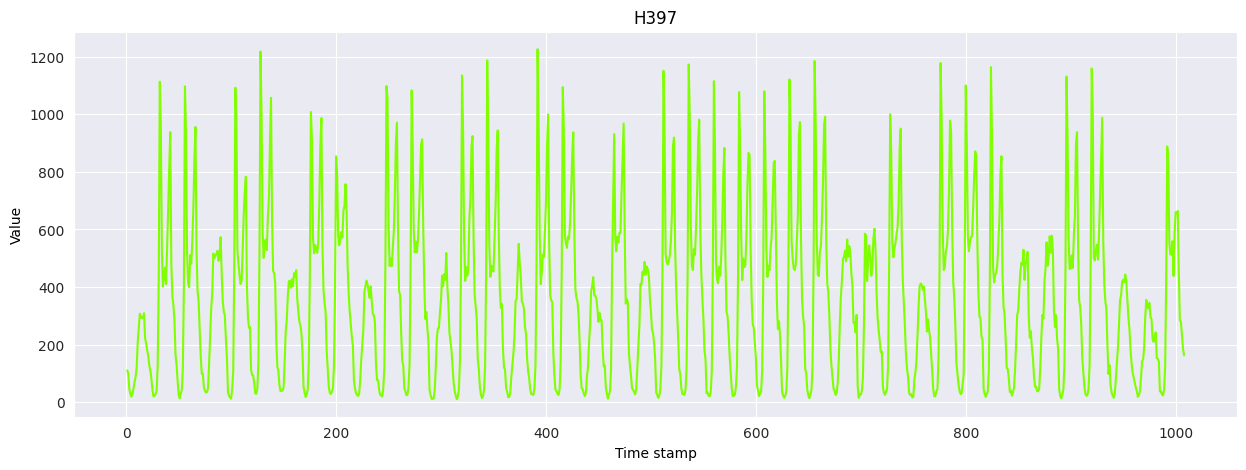

In [12]:
plot_dataset(serie, name, color = "chartreuse")

In [13]:
from mlforecast.target_transforms import LocalStandardScaler # add a standard scaler to the target to fasten the convergence of the neural network

selector = LagsSelector(MLPRegressor(hidden_layer_sizes=[2**i for i in range(4, 0, -1)],
                                     activation="relu",
                                     solver = "adam",
                                     max_iter=1000), 
                        lags = [i for i in range(1, 25)], 
                        target_transforms=[Differences([1, 24]), LocalStandardScaler()])

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
PermutationExplainer explainer: 198it [00:12,  3.13it/s]                         
 21%|██        | 5/24 [01:22<05:01, 15.85s/it]Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
 50%|█████     | 12/24 [03:14<03:00, 15.02s/it]Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
 67%|██████▋   | 16/24 [04:17<02:03, 15.43s/it]Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't c

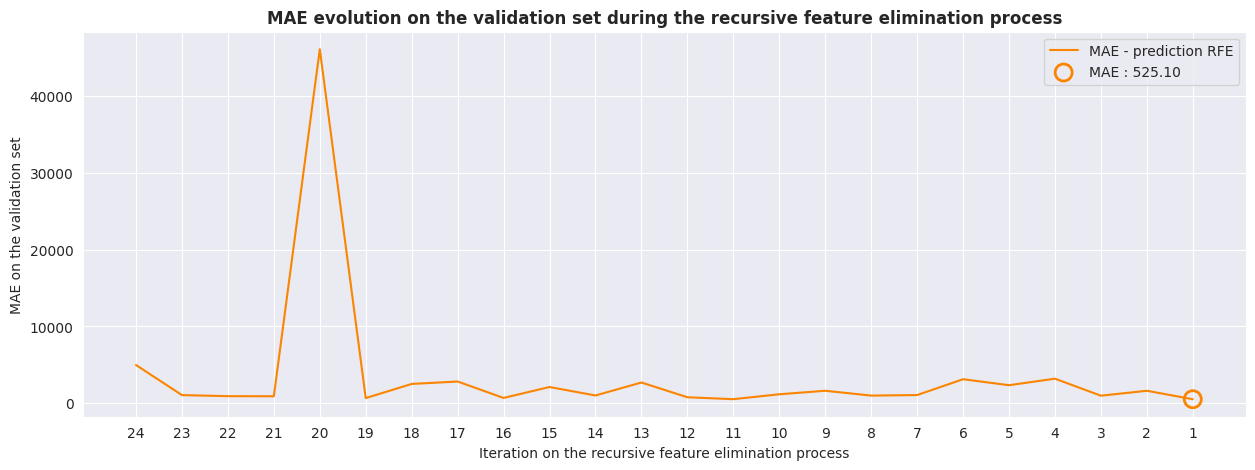

LagsSelector(best_forecaster_=None, best_params_=[24], best_score_=None,
             error_rfe_results_=None,
             prediction_rfe_results_=    n_features   mae_trn       mae_tst        R2_trn    R2_tst  lag_drop  \
0         24.0  0.483702   4977.639588 -8.762414e-01 -0.631441         1   
1         23.0  0.270247   1060.893741  6.571461e-01 -1.996806         7   
2         22.0  0.349159    922.873090  4.445945e-01 -1.023695         4   
3         21.0  0.659836    911.416207 -1.469119e+33 -0.974114         2   
4         20...
21         3.0  0.490545    983.864170 -3.715888e-01 -1.546401        21   
22         2.0  0.583032   1624.659775 -2.174649e+00 -0.965379        11   
23         1.0  0.583273    525.097221 -4.286725e+00 -2.821894        24   

     contrib  
0   0.013945  
1   0.012376  
2   0.049043  
3   0.000000  
4   0.022014  
5   0.043646  
6   0.058523  
7   0.054848  
8   0.065306  
9   0.069431  
10  0.046913  
11  0.000082  
12  0.086617  
13  0.015545  
14  0.105902  
15  0.083454  
16  0.053874  
17  0.099126  
18  0.065809  
19  0.000003  
20  0.116711  
21  0.074563  
22  0.133566  
23  0.202261  )

In [14]:
selector.fit(X = serie, explainer = "PermutationExplainer", method = "prediction")

Two things to note here : <br>
- The neural network seem to have issues to converge which means that the forecast will be suboptimal
- The error observered seem to be really high compared to the scale of the serie.

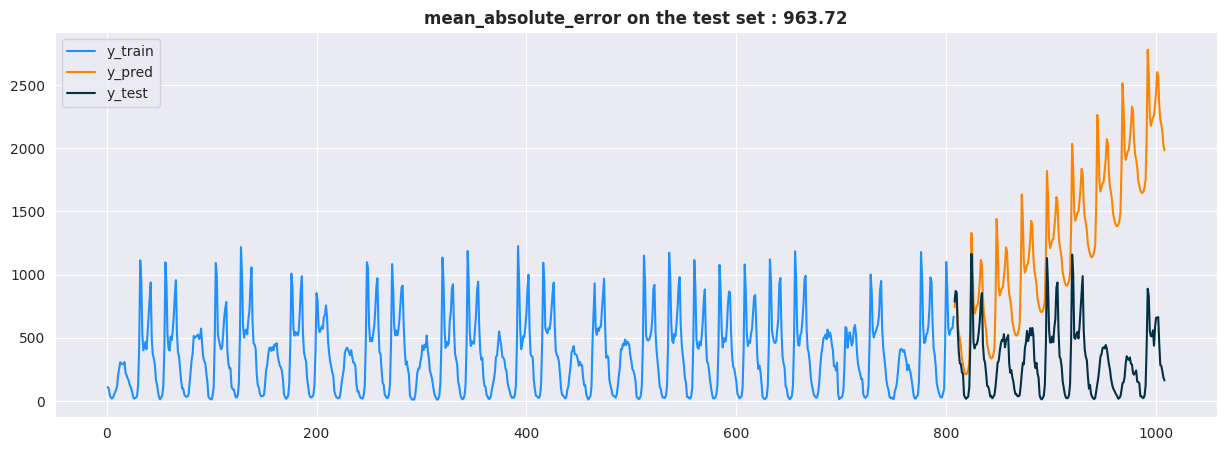

The MAE is: 963.72, i.e 338.57% of the serie's standard deviation


In [15]:
mae_eval = selector.score(plot=True, show_train=True) # passing no scoring will use the mean absolute error as default
print(f"The MAE is: {mae_eval:.2f}, i.e {mae_eval/serie['y'].std()*100:.2f}% of the serie's standard deviation")

As we thought, the neural network deeply overfit the data. We can see that the forecast of our model is good the first next few steps and then become exponentially terrible.<br><br>
This illustrate the main issue of the method, the RFE process only evaluate the forecasts at the $y_{t+1}$ step, and not at the $y_{t+h}$. In other words, the RFE does not take into account the "rolling" process of the forecast. <br><br>However, we saw with the fitting of the selector that the error was already very high at this step, which gives use another lesson : In time series, deeper is not always better. Simple models can perform far better than complex ones. Choosing the right estimator is therefore really important.

In [16]:
# Can get the best forecaster and the bests lags
fcster = selector.best_forecaster_
lags = selector.best_params_

fcster, lags

(MLForecast(models=[MLPRegressor], freq=1, lag_features=['lag24'], date_features=[], num_threads=1),
 [24])

### Custom Estimator (detrender/deseasonalizer) and Permutation explainer

If one need, he can implement his own estimator. Let's see an example here. 

In [17]:
serie = df[df['unique_id'].eq("H196")].reset_index(drop=True)
serie['ds'] = serie['ds'].astype('int64')
name = sample_uids[0]

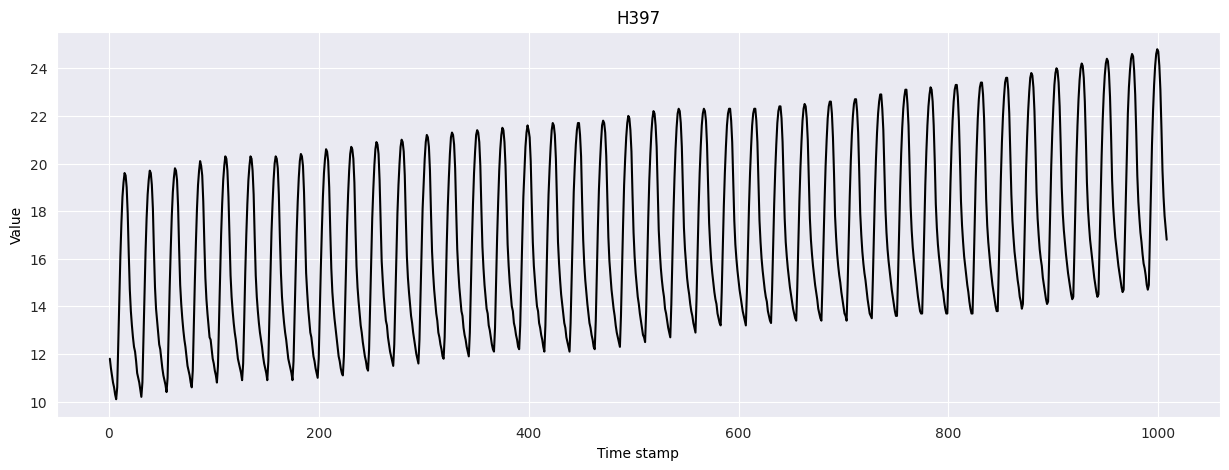

In [18]:
plot_dataset(serie, name, color = "black")

The serie is very simple, we will just extract trend and seasonality and forecast them without any other computations. 

In [19]:
# the estimator must include a fit and a predict method.
class Zeros(BaseEstimator):
    def fit(self, X: ndarray, y=None):
        return self

    def predict(self, X: ndarray, y=None):
        return zeros(X.shape[0])


selector = LagsSelector(Zeros(), 
                        lags = [i for i in range(1, 25)], 
                        target_transforms=[Differences([1, 24]), LocalStandardScaler()]) # To detrend/deseasonalize the serie.

In [20]:
selector.fit(X = serie, explainer = "PermutationExplainer", method = "error", plot = False)

100%|██████████| 24/24 [00:48<00:00,  2.01s/it]


LagsSelector(best_forecaster_=None,
             best_params_=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                           16, 17, 18, 19, 20, 21, 22, 23, 24],
             best_score_=None,
             error_rfe_results_=    n_features   mae_trn   mae_tst  R2_trn   R2_tst  lag_drop  contrib
0         24.0  0.640853  4.874439     0.0 -1.57059         1      0.0
1         23.0  0.640853  4.874439     0.0 -1.57059         2      0.0
2         22.0  0.640853  4.874439     0.0 -1.57059         3      0.0
3         21.0  0.640853  4.874439     0.0 -1.57059         4      0.0
4         20.0  0...
15         9.0  0.640853  4.874439     0.0 -1.57059        16      0.0
16         8.0  0.640853  4.874439     0.0 -1.57059        17      0.0
17         7.0  0.640853  4.874439     0.0 -1.57059        18      0.0
18         6.0  0.640853  4.874439     0.0 -1.57059        19      0.0
19         5.0  0.640853  4.874439     0.0 -1.57059        20      0.0
20         4.0  0.640853  4.874439     0.0 -1.57059        21      0.0
21         3.0  0.640853  4.874439     0.0 -1.57059        22      0.0
22         2.0  0.640853  4.874439     0.0 -1.57059        23      0.0
23         1.0  0.640853  4.874439     0.0 -1.57059        24      0.0,
             prediction_rfe_results_=None)

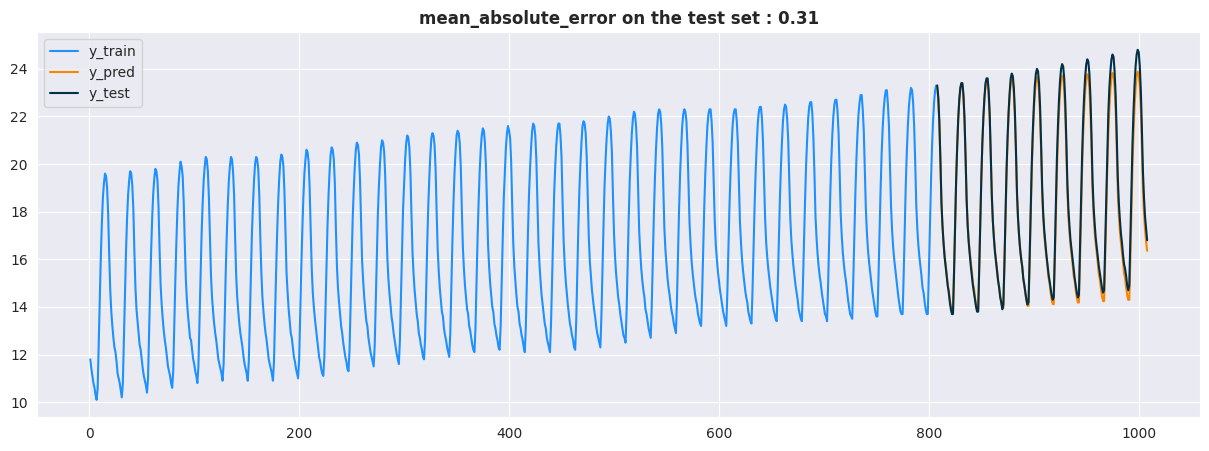

The MAE is: 0.31, i.e 8.44% of the serie's standard deviation


In [21]:
mae_eval = selector.score(plot=True, show_train=True)
print(f"The MAE is: {mae_eval:.2f}, i.e {mae_eval/serie['y'].std()*100:.2f}% of the serie's standard deviation")

We can see that in some cases like this one, the simplest estimator can give good results, it's just a matter of preprocessing.